**Temat:** Analiza sentymentu w tekstach internetowych w oparciu o sieci typu Transformer

**Wprowadzenie:** Analiza sentymentu to technika przetwarzania języka naturalnego (NLP), która identyfikuje ton emocjonalny w tekście, klasyfikując go na pozytywny, negatywny lub neutralny. Wykorzystuje się ją do badania opinii klientów, monitorowania reputacji marki czy analizy treści mediów społecznościowych.

**Cel projektu:** Celem projektu jest opracowanie i implementacja modelu analizy sentymentu, który pozwoli na klasyfikację opinii użytkowników na podstawie tekstów pochodzących z Internetu. Należy przeanalizować dane tekstowe, przygotować odpowiedni model oraz zaprezentować wyniki analizy.

### Konfiguracja środowiska 

In [1]:
%pip install datasets transformers torch langdetect scikit-learn seaborn pandas matplotlib wordcloud nltk spacy jieba --quiet

Note: you may need to restart the kernel to use updated packages.


### Ładowanie danych

In [2]:
from datasets import load_dataset

ds = load_dataset("clapAI/MultiLingualSentiment")

/Users/michalklos/Studia_Projekty/NLP/Multilingual-sentiment-analysis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 3147478
    })
    validation: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393435
    })
    test: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393436
    })
})


### Redukcja datasetów, wymieszanie rekordów oraz podział na język + typ zbioru

In [4]:
languages = ds['train'].unique('language')
ds_types = ['train', 'validation', 'test']
drop_columns = ['source', 'domain']
languages_to_process = ['en', 'es', 'zh']
ds = ds.remove_columns(drop_columns)
# Create dictionary to store datasets for each language
datasets = {}

# Split train, validation and test for each language
for lang in languages_to_process:
    datasets[lang] = {}
    for ds_type in ds_types:
        datasets[lang][ds_type] = ds[ds_type].filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc=4
            )
        
        # Reduce dataset by 100 times
        rows_counter = datasets[lang][ds_type].num_rows
        new_num_rows = round(rows_counter*0.01)
        datasets[lang][ds_type] = datasets[lang][ds_type].shuffle(seed=42)
        datasets[lang][ds_type] = datasets[lang][ds_type].select(range(new_num_rows))

### Czyszczenie datasetów z błędnych języków

W zbiorze angielskim występowały próbki niechcianych języków np. turecki

In [5]:
from langdetect import detect
import copy

dataset_copy = copy.deepcopy(datasets)

def detect_language(text):
    try:
        detected = detect(text)
        if detected.startswith('zh'):
            return 'zh'
        elif detected == 'es':
            return 'es'
        elif detected == 'en':
            return 'en'
        return detected
    except:
        return "unknown"
    
for ds_type in ds_types:
        for lang in languages_to_process:
            datasets[lang][ds_type] = datasets[lang][ds_type].filter(
                lambda batch: [detect_language(x) == lang for x in batch['text']],
                batched=True,
                num_proc=4
            )

In [6]:
# calculate how many rows were removed
for lang in languages_to_process:
    for ds_type in ds_types:
        original_rows = dataset_copy[lang][ds_type].num_rows
        filtered_rows = datasets[lang][ds_type].num_rows
        removed_rows = original_rows - filtered_rows
        print(f"Language: {lang}, Dataset Type: {ds_type}, Filtered rows: {filtered_rows}, Removed rows: {removed_rows}")

print('Sample en: ', datasets['en']['train'][0])
print('Sample zh: ', datasets['zh']['train'][0])
print('Sample es: ', datasets['es']['train'][0])

Language: en, Dataset Type: train, Filtered rows: 10302, Removed rows: 1855
Language: en, Dataset Type: validation, Filtered rows: 1307, Removed rows: 215
Language: en, Dataset Type: test, Filtered rows: 1284, Removed rows: 235
Language: es, Dataset Type: train, Filtered rows: 1753, Removed rows: 31
Language: es, Dataset Type: validation, Filtered rows: 219, Removed rows: 2
Language: es, Dataset Type: test, Filtered rows: 220, Removed rows: 4
Language: zh, Dataset Type: train, Filtered rows: 3242, Removed rows: 320
Language: zh, Dataset Type: validation, Filtered rows: 405, Removed rows: 39
Language: zh, Dataset Type: test, Filtered rows: 396, Removed rows: 47
Sample en:  {'text': 'Not allowed to withdraw my funds, and was told I can only cash out if I deactivate or close the account. Well if u say so.', 'label': 'negative', 'language': 'en'}
Sample zh:  {'text': '妈妈说非常好，谢谢店家，会继续支持', 'label': 'positive', 'language': 'zh'}
Sample es:  {'text': 'Cada vez que como termino yendo al baño a 

### Przygotowanie datasetów z wybranymi językami

W ramach naszego usecase'u wybraliśmy 3 języki - angielski, hiszpański oraz chiński. Do rekordów dodaliśmy label_id jako wartość predykcyjna do uczenia.

In [7]:
from datasets import concatenate_datasets

labels_id = {'negative': 0, 'neutral': 1, 'positive': 2}

# Convert labels to IDs
def convert_labels_to_ids(batch):
    batch['label_id'] = [labels_id[label] for label in batch['label']]
    return batch

# train ds
train_ds_list = [datasets[lang]['train'] for lang in languages_to_process]
# Concatenate datasets for selected languages
train_ds = concatenate_datasets(train_ds_list)
train_ds = train_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
train_ds = train_ds.shuffle(seed=42)

# eval ds
eval_ds_list = [datasets[lang]['validation'] for lang in languages_to_process]
# Concatenate datasets for selected languages
eval_ds = concatenate_datasets(eval_ds_list)
eval_ds = eval_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
eval_ds = eval_ds.shuffle(seed=42)

# test ds
test_ds_list = [datasets[lang]['test'] for lang in languages_to_process]
# Concatenate datasets for selected languages
test_ds = concatenate_datasets(test_ds_list)
test_ds = test_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
test_ds = test_ds.shuffle(seed=42)

In [8]:
print(train_ds[1])

{'text': 'Cumple con expectativas.\nEstoy satisfecho tanto con el artículo como con el tiempo que he tardado en recibirlo. Seguiré utilizando este medio para obtener algún producto más.', 'label': 'neutral', 'language': 'es', 'label_id': 1}


### Eksploracja zbioru treningowego

Jak mozna zauwazyć niestety w zbiorach dane nie są równo rozłozone między wszystkie języki i etykiety, ale to nie stanowi dla nas problemu w trenowaniu modelu.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'green'}
label_order = ['negative', 'neutral', 'positive']

def create_label_distribution_plot(data, title, output_path):
    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        data=data,
        x='label',
        y='count',
        order=label_order,
        palette=[label_colors[x] for x in label_order]
    )
    
    for i, v in enumerate(data.set_index('label').loc[label_order, 'count']):
        ax.text(i, v, str(v), ha='center', va='bottom')
    
    plt.title(title)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

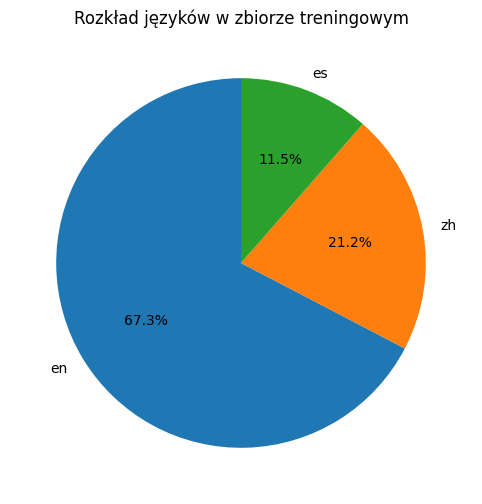

In [10]:
train_pd = train_ds.to_pandas()
language_stats = train_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze treningowym')

plt.savefig('images/language_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_99111/1488427961.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


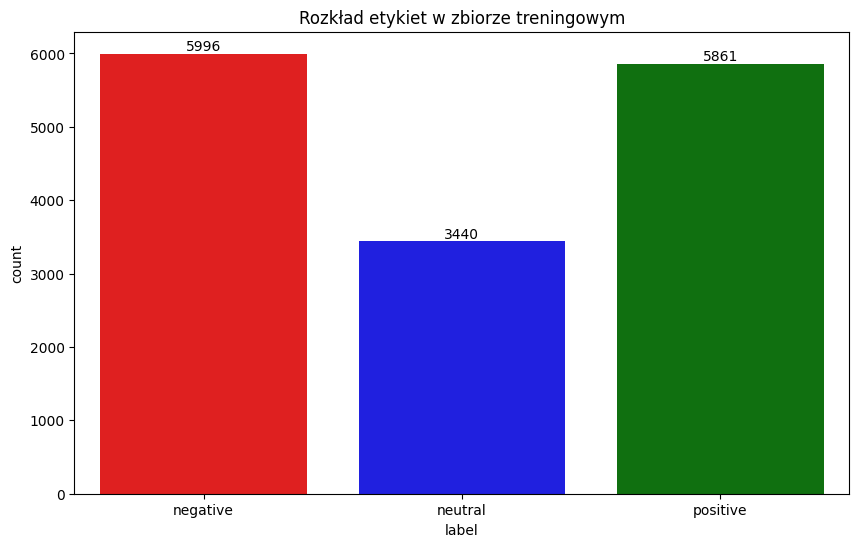

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
label_stats_train = train_pd['label'].value_counts().reset_index()
label_stats_train.columns = ['label', 'count']
create_label_distribution_plot(
    label_stats_train,
    'Rozkład etykiet w zbiorze treningowym',
    'images/label_distribution_train.png'
)

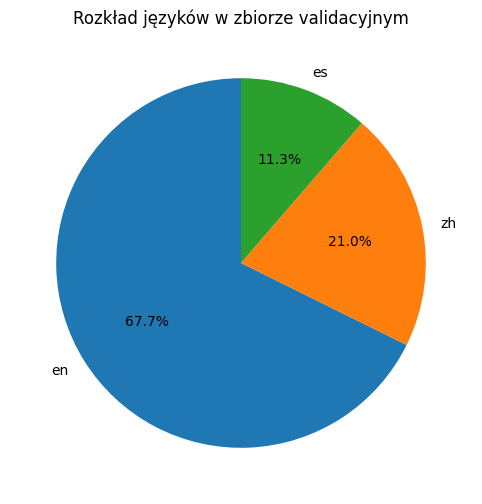

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
language_stats = eval_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze validacyjnym')

plt.savefig('images/language_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_99111/1488427961.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


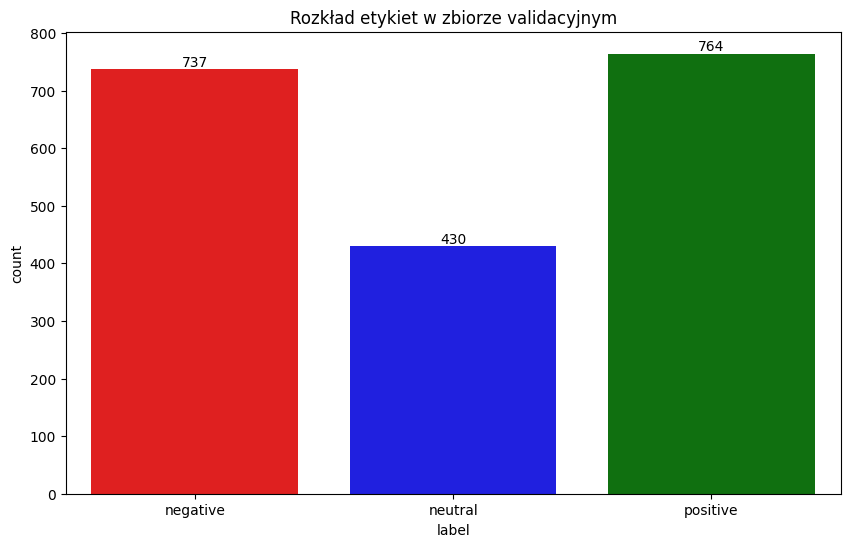

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
label_stats_eval = eval_pd['label'].value_counts().reset_index()
label_stats_eval.columns = ['label', 'count']
create_label_distribution_plot(
    label_stats_eval,
    'Rozkład etykiet w zbiorze validacyjnym',
    'images/label_distribution_eval.png'
)

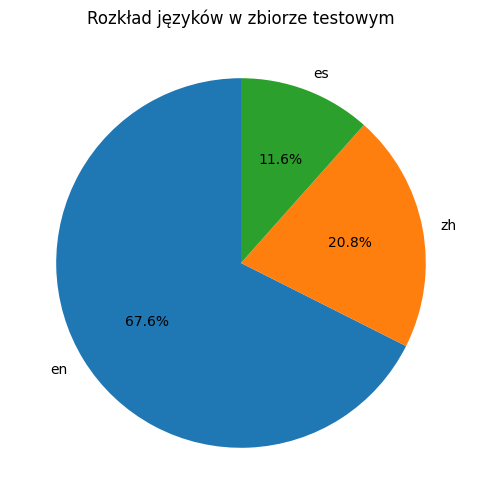

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
language_stats = test_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze testowym')

plt.savefig('images/language_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_99111/1488427961.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


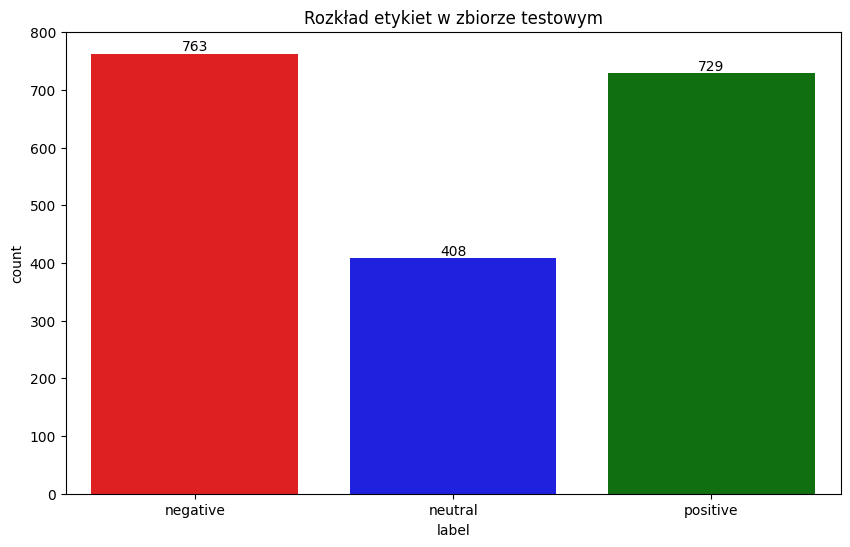

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
label_stats_test = test_pd['label'].value_counts().reset_index()
label_stats_test.columns = ['label', 'count']
create_label_distribution_plot(
    label_stats_test,
    'Rozkład etykiet w zbiorze testowym',
    'images/label_distribution_test.png'
)

### Wordclouds

In [16]:
import re
import nltk
import spacy
import jieba
from nltk.corpus import stopwords

Opcjonalne: przy problemach nltk z SSL:

In [17]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [18]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("es_core_news_sm")
spacy.cli.download("zh_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.3 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 15.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 27.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')


In [19]:
nltk.download('stopwords')

# Initialize spacy models
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'zh': spacy.load('zh_core_web_sm')
}

# Get stopwords
stop_words = {
    'en': set(stopwords.words('english')),
    'es': set(stopwords.words('spanish')),
    'zh': set()  # Chinese doesn't use stopwords
}

additional_spanish_stops = {
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas',
    'lo', 'al', 'del', 'este', 'esta', 'estos', 'estas',
    'ese', 'esa', 'esos', 'esas', 'aquel', 'aquella',
    'muy', 'mucho', 'muchos', 'muchas', 'más', 'menos'
}
stop_words['es'].update(additional_spanish_stops)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michalklos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def remove_special_and_digits(txt, lang):
    # Remove special characters but keep Spanish-specific characters
    if lang == 'es':
        txt = re.sub(r'[^a-záéíóúüñA-ZÁÉÍÓÚÜÑ\s]', '', txt)
    else:
        txt = re.sub(r'[^a-zA-Z\u4e00-\u9fff\s]', '', txt)

    if lang == 'zh':
        txt = " ".join(jieba.cut(txt))

    if lang != 'zh':
        txt = txt.lower()
    
    document = nlp_models[lang](txt)

    tokens = []
    if lang == 'zh':
        tokens = [token.text for token in document if 
                (not token.is_stop and not token.is_space and
                len(token.text.strip()) > 0)]
    else:
        for token in document:
            # More aggressive stopword filtering for Spanish
            if lang == 'es':
                if (token.text.lower() not in stop_words['es'] and 
                    not token.is_space and 
                    len(token.text.strip()) > 0 and
                    not token.is_punct and
                    not token.like_num):
                    tokens.append(token.lemma_)
            else:
                if (token.text not in stop_words.get(lang, set()) and 
                    not token.is_space and 
                    len(token.text.strip()) > 0):
                    tokens.append(token.lemma_)
    
    return ' '.join(tokens)

def preprocess_dataset(example):
    example['preprocessed_text'] = remove_special_and_digits(
        example['text'], 
        example['language']
    )

    return example

In [21]:
print(train_ds)

preprocessed_dataset = train_ds.map(
    preprocess_dataset,
    num_proc=4, 
    batch_size=100
)

print("\nOriginal text:", preprocessed_dataset[0]['text'])
print("Preprocessed text:", preprocessed_dataset[0]['preprocessed_text'])
print("Preprocessed tokens:", preprocessed_dataset[0]['preprocessed_text'].split())

Dataset({
    features: ['text', 'label', 'language', 'label_id'],
    num_rows: 15297
})

Original text: 坏的！电源线接音箱接触不良，用手扶着调整才能有声音，放手就无声音。处理方式只能退。海外购退货太麻烦了。电子产品还只能海运，三个月到货后才退款，或者有的快递公司运费快赶上产品价格。东西再吸引，下手也得三思。以后也不敢买了。
Preprocessed text: 坏 电源线 接 音箱 接触 不良 手扶 调整 声音 放手 声音 方式 只能 退 海外 购 退货 太 麻烦 电子 产品 只能 海运 月 到货 退款 快递 公司 运费 赶上 产品 价格 东西 吸引 下手 三思 买
Preprocessed tokens: ['坏', '电源线', '接', '音箱', '接触', '不良', '手扶', '调整', '声音', '放手', '声音', '方式', '只能', '退', '海外', '购', '退货', '太', '麻烦', '电子', '产品', '只能', '海运', '月', '到货', '退款', '快递', '公司', '运费', '赶上', '产品', '价格', '东西', '吸引', '下手', '三思', '买']


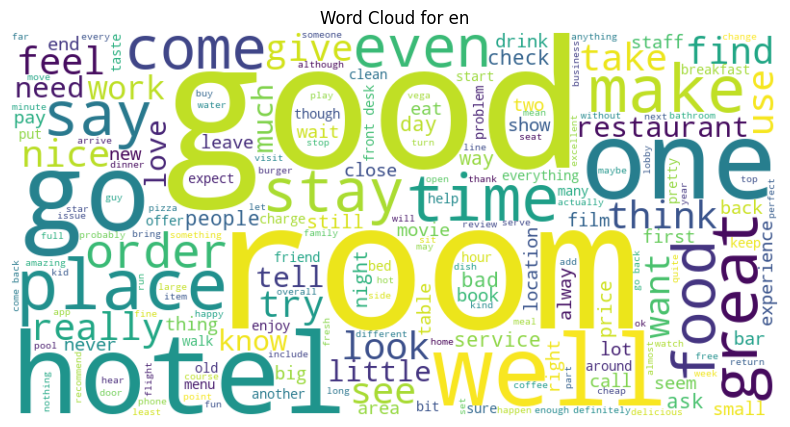

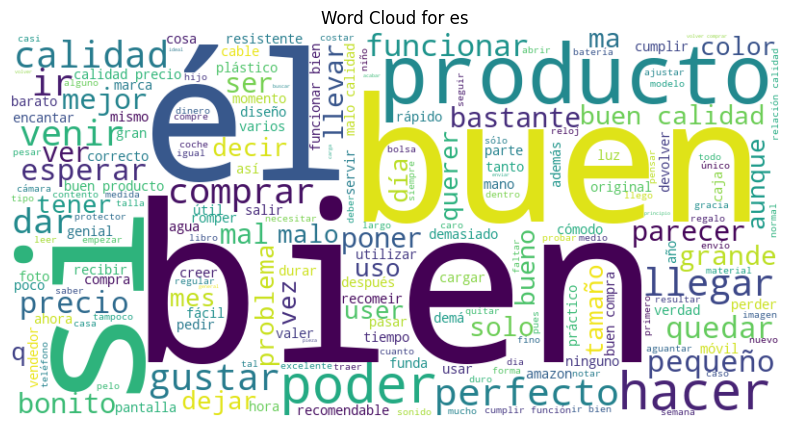

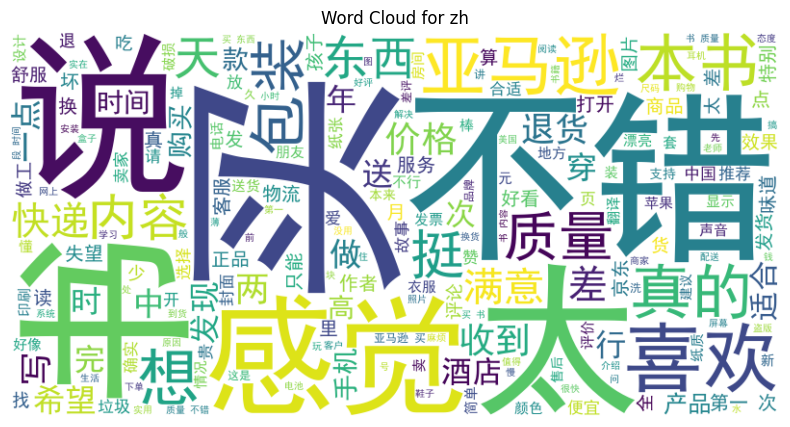

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

font_path = './resources/simhei.ttf'  # Path to a Chinese font file for word cloud

# Create word cloud for each language
for lang in languages_to_process:
    # Filter dataset by language
    lang_texts = ' '.join(preprocessed_dataset.filter(
        lambda x: x['language'] == lang
    )['preprocessed_text'])
    
    # Create and display word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        font_path=font_path if lang == 'zh' else None,  # Use Chinese font for Chinese text
    ).generate(lang_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {lang}')
    plt.show()

    wordcloud.to_file(f'./wordclouds/wordcloud_{lang}.png')  # Save word cloud to file

### Tokenizacja

W ramach tego etapu załadowaliśmy juz wstępnie wytrenowany model i tokenizator z bert-base-multilingual-cased i dokonaliśmy tokenizacji zbioru treningowego i validacyjnego

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

def tokenize_and_encode(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # BERT max sequence length
        # return_tensors=None,  # Returns PyTorch tensors
        # return_special_tokens_mask=True
    )



tokenized_train_ds = train_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_train_ds = tokenized_train_ds.rename_column("label_id", "label")
tokenized_eval_ds = eval_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_eval_ds = tokenized_eval_ds.rename_column("label_id", "label")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
print(tokenized_train_ds[0])

{'label': 2, 'input_ids': [101, 3767, 3392, 5605, 10064, 5286, 7520, 1882, 1882, 1882, 131, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Trening

W ramach treningu dodaliśmy własną funkcję compute_metrics, która ma na celu obliczanie accuracy oraz f1 po validacji kazdej z epok

In [48]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

model.to('cpu')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir="./multilingual_bert_sentiment",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("./multilingual_bert_sentiment")
trainer.evaluate()

/var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/ipykernel_34965/1482221042.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 